In [1]:
%matplotlib inline

In [2]:
import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torch.optim as optim
from torchsummary import summary
from keras.utils import to_categorical
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchviz
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.misc import imresize

from gluoncv import data, utils

Using TensorFlow backend.


In [3]:
class VOC2012_Dataset(Dataset):
    def __init__(self, root_dir, splits=[(2012, 'trainval')], transform=None):
        self.root_dir = root_dir
        self.splits = splits
        self.transform = transform
        
        self.read_dataset()
        
        self.classes = self.data.classes
        
    def read_dataset(self):
        self.data = data.VOCDetection(root=self.root_dir, splits=[(2012, 'trainval')])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        
        image = PIL.Image.fromarray(image.asnumpy())
        label = label[:,4:5]
        
        label = np.max(to_categorical(label, len(self.data.classes)), axis=0)
        
        if self.transform:
            image = self.transform(image)
           
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        sample = image.to(device), torch.torch.from_numpy(label).to(device)

        
        return sample

In [4]:
def train_val_split(dataset, p=.8, use_p_of_data=1):
    if p > 1 or p < 0:
        return None
    length = int(np.ceil(use_p_of_data * len(dataset)))
    split = int(np.ceil(p * length))
    index_list = list(range(length))
    
    train_idx, val_idx = index_list[:split], index_list[split:]
    return train_idx, val_idx

In [5]:
image_size = 448
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# image pre-processor
train_transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize([image_size, image_size]),
    torchvision.transforms.RandomHorizontalFlip(p=.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize([image_size, image_size]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

print(train_transformer)

Compose(
    Resize(size=[448, 448], interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [6]:
root=r"D:\Drive D\books\university lesson books\arshad\Deep Learning\Project\PRM-pytorch\demo"
BATCH_SIZE = 2
PERCENT_OF_DATA = .2
TRAIN_VAL_SPLIT = .8

In [7]:
dataset = VOC2012_Dataset(root, transform=train_transformer)

train_idx, val_idx = train_val_split(dataset, p=TRAIN_VAL_SPLIT, use_p_of_data=PERCENT_OF_DATA)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_dloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True, shuffle=False)
val_dloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler, drop_last=True, shuffle=False)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
from model.fcn_ran import FCN_RAN

In [10]:
backbone = FCN_RAN(num_classes=20).to(device)

print(backbone)

d:\drive d\books\university lesson books\arshad\payann~1\env\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


FCN_RAN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResidualBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=

)


In [11]:
summary(backbone, (3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]           2,048
       BatchNorm2d-8         [-1, 32, 112, 112]              64
              ReLU-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           9,216
      BatchNorm2d-11         [-1, 32, 112, 112]              64
             ReLU-12         [-1, 32, 112, 112]               0
           Conv2d-13        [-1, 128, 112, 112]           4,096
           Conv2d-14        [-1, 128, 1

            ReLU-252           [-1, 64, 14, 14]               0
          Conv2d-253          [-1, 256, 14, 14]          16,384
   ResidualBlock-254          [-1, 256, 14, 14]               0
     BatchNorm2d-255          [-1, 256, 14, 14]             512
            ReLU-256          [-1, 256, 14, 14]               0
          Conv2d-257           [-1, 64, 14, 14]          16,384
     BatchNorm2d-258           [-1, 64, 14, 14]             128
            ReLU-259           [-1, 64, 14, 14]               0
          Conv2d-260           [-1, 64, 14, 14]          36,864
     BatchNorm2d-261           [-1, 64, 14, 14]             128
            ReLU-262           [-1, 64, 14, 14]               0
          Conv2d-263          [-1, 256, 14, 14]          16,384
   ResidualBlock-264          [-1, 256, 14, 14]               0
       MaxPool2d-265            [-1, 256, 7, 7]               0
     BatchNorm2d-266            [-1, 256, 7, 7]             512
            ReLU-267            [-1, 256

            ReLU-506            [-1, 128, 7, 7]               0
          Conv2d-507            [-1, 128, 7, 7]         147,456
     BatchNorm2d-508            [-1, 128, 7, 7]             256
            ReLU-509            [-1, 128, 7, 7]               0
          Conv2d-510            [-1, 512, 7, 7]          65,536
   ResidualBlock-511            [-1, 512, 7, 7]               0
UpsamplingBilinear2d-512          [-1, 512, 14, 14]               0
     BatchNorm2d-513          [-1, 512, 14, 14]           1,024
            ReLU-514          [-1, 512, 14, 14]               0
          Conv2d-515          [-1, 128, 14, 14]          65,536
     BatchNorm2d-516          [-1, 128, 14, 14]             256
            ReLU-517          [-1, 128, 14, 14]               0
          Conv2d-518          [-1, 128, 14, 14]         147,456
     BatchNorm2d-519          [-1, 128, 14, 14]             256
            ReLU-520          [-1, 128, 14, 14]               0
          Conv2d-521          [-1, 5

          Conv2d-760         [-1, 1024, 14, 14]         262,144
   ResidualBlock-761         [-1, 1024, 14, 14]               0
AttentionModule_stage3-762         [-1, 1024, 14, 14]               0
     BatchNorm2d-763         [-1, 1024, 14, 14]           2,048
            ReLU-764         [-1, 1024, 14, 14]               0
          Conv2d-765          [-1, 512, 14, 14]         524,288
     BatchNorm2d-766          [-1, 512, 14, 14]           1,024
            ReLU-767          [-1, 512, 14, 14]               0
          Conv2d-768          [-1, 512, 14, 14]       2,359,296
     BatchNorm2d-769          [-1, 512, 14, 14]           1,024
            ReLU-770          [-1, 512, 14, 14]               0
          Conv2d-771         [-1, 2048, 14, 14]       1,048,576
          Conv2d-772         [-1, 2048, 14, 14]       2,097,152
   ResidualBlock-773         [-1, 2048, 14, 14]               0
     BatchNorm2d-774         [-1, 2048, 14, 14]           4,096
            ReLU-775         [-1, 

In [11]:
from modules import PeakResponseMapping

In [12]:
model = PeakResponseMapping(
    backbone, 
    enable_peak_stimulation = True,
    enable_peak_backprop = True, 
    win_size = 3, 
    sub_pixel_locating_factor = 1, 
    filter_type = 'median').to(device)

print(model)

PeakResponseMapping(
  (0): FCN_RAN(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (2): ResidualBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv

)


In [13]:
model[0].attention

[AttentionModule_stage0(
   (first_residual_blocks): ResidualBlock(
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace)
     (conv1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (conv4): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   )
   (trunk_branches): Sequential(
     (0): ResidualBlock(
       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace)
       (conv1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn2): BatchNorm2d(32, eps=1e-0

In [14]:
summary(model, (3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]           2,048
       BatchNorm2d-8         [-1, 32, 112, 112]              64
              ReLU-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           9,216
      BatchNorm2d-11         [-1, 32, 112, 112]              64
             ReLU-12         [-1, 32, 112, 112]               0
           Conv2d-13        [-1, 128, 112, 112]           4,096
           Conv2d-14        [-1, 128, 1

            ReLU-252           [-1, 64, 14, 14]               0
          Conv2d-253          [-1, 256, 14, 14]          16,384
   ResidualBlock-254          [-1, 256, 14, 14]               0
     BatchNorm2d-255          [-1, 256, 14, 14]             512
            ReLU-256          [-1, 256, 14, 14]               0
          Conv2d-257           [-1, 64, 14, 14]          16,384
     BatchNorm2d-258           [-1, 64, 14, 14]             128
            ReLU-259           [-1, 64, 14, 14]               0
          Conv2d-260           [-1, 64, 14, 14]          36,864
     BatchNorm2d-261           [-1, 64, 14, 14]             128
            ReLU-262           [-1, 64, 14, 14]               0
          Conv2d-263          [-1, 256, 14, 14]          16,384
   ResidualBlock-264          [-1, 256, 14, 14]               0
       MaxPool2d-265            [-1, 256, 7, 7]               0
     BatchNorm2d-266            [-1, 256, 7, 7]             512
            ReLU-267            [-1, 256

            ReLU-506            [-1, 128, 7, 7]               0
          Conv2d-507            [-1, 128, 7, 7]         147,456
     BatchNorm2d-508            [-1, 128, 7, 7]             256
            ReLU-509            [-1, 128, 7, 7]               0
          Conv2d-510            [-1, 512, 7, 7]          65,536
   ResidualBlock-511            [-1, 512, 7, 7]               0
UpsamplingBilinear2d-512          [-1, 512, 14, 14]               0
     BatchNorm2d-513          [-1, 512, 14, 14]           1,024
            ReLU-514          [-1, 512, 14, 14]               0
          Conv2d-515          [-1, 128, 14, 14]          65,536
     BatchNorm2d-516          [-1, 128, 14, 14]             256
            ReLU-517          [-1, 128, 14, 14]               0
          Conv2d-518          [-1, 128, 14, 14]         147,456
     BatchNorm2d-519          [-1, 128, 14, 14]             256
            ReLU-520          [-1, 128, 14, 14]               0
          Conv2d-521          [-1, 5

          Conv2d-760         [-1, 1024, 14, 14]         262,144
   ResidualBlock-761         [-1, 1024, 14, 14]               0
AttentionModule_stage3-762         [-1, 1024, 14, 14]               0
     BatchNorm2d-763         [-1, 1024, 14, 14]           2,048
            ReLU-764         [-1, 1024, 14, 14]               0
          Conv2d-765          [-1, 512, 14, 14]         524,288
     BatchNorm2d-766          [-1, 512, 14, 14]           1,024
            ReLU-767          [-1, 512, 14, 14]               0
          Conv2d-768          [-1, 512, 14, 14]       2,359,296
     BatchNorm2d-769          [-1, 512, 14, 14]           1,024
            ReLU-770          [-1, 512, 14, 14]               0
          Conv2d-771         [-1, 2048, 14, 14]       1,048,576
          Conv2d-772         [-1, 2048, 14, 14]       2,097,152
   ResidualBlock-773         [-1, 2048, 14, 14]               0
     BatchNorm2d-774         [-1, 2048, 14, 14]           4,096
            ReLU-775         [-1, 

In [13]:
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output, display

def train(model, data_loader, epochs, criterion=None, optimizer=None):
    
#     print("initialiing...")
    if criterion == None:
        criterion = nn.MultiLabelSoftMarginLoss()
    if optimizer == None:
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1.0e-4)

    for e in tqdm_notebook(range(epochs), desc='Epochs:'):
        print("Epoch %02d:" % (e+1), end='\r\n')
        running_loss = 0.0
        with tqdm_notebook(range(len(data_loader)), desc='Batchs:') as pbar:
            for i, data in enumerate(data_loader):
                pbar.update(1)
                inputs, label = data
                assert type(inputs) == torch.Tensor, "Input must be torch.Tensor but got %s" % type(inputs)

                optimizer.zero_grad()

                outputs = model(inputs)

                loss = criterion(outputs, label)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
                print('Batch [%4d] loss: %.3f' %
                  (i + 1, loss.item()), end='\r')
            
        print('[%d] loss: %.3f' %
              (e + 1, running_loss / len(data_loader)))
        running_loss = 0.0

In [19]:
train(model, train_dloader, epochs=1)

Epoch 01:


KeyboardInterrupt: 

In [14]:
model.load_state_dict(torch.load(r".\modelZoo\statdict_ran.pth", map_location='cpu'))

In [14]:
model = model.eval()

d:\drive d\books\university lesson books\arshad\payann~1\env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([1, 3, 448, 448])


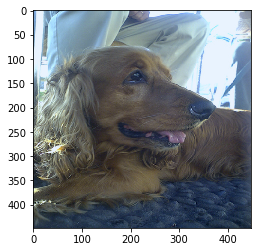

In [15]:
# input_var, lbl = next(iter(train_dloader))
input_var = dataset[28][0].view(1,3,448,448)
plt.imshow(imresize(input_var[0].permute(1, 2, 0), (image_size, image_size), interp='bicubic'))
print(input_var.shape)

In [20]:
# mpool1 = [3, 5, 7, 8, 10, 11, 12]
# for i in mpool1:
#     model[0].features[i].mpool1.requires_grad = False


# for module in model.modules():
#     if isinstance(module, nn.UpsamplingBilinear2d):
#         module.requires_grad = False

torch.Size([1, 20])


Object categories in the image:
    [class_idx: 0] aeroplane (-4.78)
    [class_idx: 1] bicycle (-4.62)
    [class_idx: 2] bird (-4.45)
    [class_idx: 3] boat (-5.01)
    [class_idx: 4] bottle (-3.30)
    [class_idx: 5] bus (-4.82)
    [class_idx: 6] car (-2.92)
    [class_idx: 7] cat (-4.35)
    [class_idx: 8] chair (-2.67)
    [class_idx: 9] cow (-6.38)
    [class_idx: 10] diningtable (-4.21)
    [class_idx: 11] dog (-3.68)
    [class_idx: 12] horse (-4.28)
    [class_idx: 13] motorbike (-4.31)
    [class_idx: 14] person (0.33)
    [class_idx: 15] pottedplant (-3.80)
    [class_idx: 16] sheep (-6.65)
    [class_idx: 17] sofa (-3.71)
    [class_idx: 18] train (-3.90)
    [class_idx: 19] tvmonitor (-3.98)


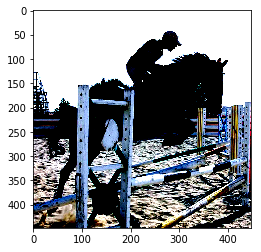

In [15]:
confidence = model(input_var)
print(confidence.shape)
plt.imshow(  input_var[0].permute(1, 2, 0)  )
# _, preds = torch.max(lbl, 1)
# print(lbl)
# print("preds => " ,preds.data)
print('Object categories in the image:')
# print("max " , torch.max(confidence[1, idx] )
      
for idx in range(len(dataset.classes)):
#     if confidence.data[1, idx] > 0:
      print('    [class_idx: %d] %s (%.2f)' % (idx, dataset.classes[idx], confidence[0, idx]))

In [17]:
graph = torchviz.make_dot(confidence)
graph.format = 'svg'
graph.render(filename='img/g1')

'img/g1.svg'

In [16]:
model = model.inference()

In [16]:
# mpool1 = [3, 5, 7, 8, 10, 11, 12]
# for i in mpool1:
#     model[0].features[i].mpool1.requires_grad = False

d:\drive d\books\university lesson books\arshad\payann~1\env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.


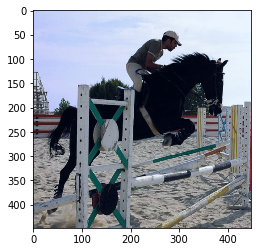

In [20]:
plt.imshow(imresize(input_var[0].permute(1, 2, 0), (image_size, image_size), interp='bicubic'))

class_threshold =  tensor(-3.6726, grad_fn=<MedianBackward1>)
peak_threshold =  tensor(-1., grad_fn=<TruncBackward>)
peak_val =  tensor(-1.7228, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.4863, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.3028, grad_fn=<SelectBackward>)
peak_val =  tensor(-2.1030, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.7927, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.9530, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.4092, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.5201, grad_fn=<SelectBackward>)
peak_val =  tensor(-2.4174, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.3874, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.2540, grad_fn=<SelectBackward>)
peak_val =  tensor(-2.5097, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.5117, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.5925, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.2915, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.8930, grad_fn=<SelectBackward>)
peak_val =  tensor(

peak_val =  tensor(-1.1652, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.4342, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.1550, grad_fn=<SelectBackward>)
peak_val =  tensor(-0.5289, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.8215, grad_fn=<SelectBackward>)
peak_val =  tensor(-2.0911, grad_fn=<SelectBackward>)
peak_val =  tensor(0.0856, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.6312, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.8179, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.8111, grad_fn=<SelectBackward>)
peak_val =  tensor(1.0190, grad_fn=<SelectBackward>)
peak_val =  tensor(-1.3957, grad_fn=<SelectBackward>)
peak_val =  tensor(0.6933, grad_fn=<SelectBackward>)
peak_val =  tensor(-0.9909, grad_fn=<SelectBackward>)
peak_val =  tensor(-0.3063, grad_fn=<SelectBackward>)
peak_val =  tensor(-2.2483, grad_fn=<SelectBackward>)
peak_val =  tensor(-0.6900, grad_fn=<SelectBackward>)
peak_val =  tensor(-2.4089, grad_fn=<SelectBackward>)
peak_val =  tensor(-2.3804, gra

          2.7543e-09, 1.3010e-09]]]))


d:\drive d\books\university lesson books\arshad\payann~1\env\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # This is added back by InteractiveShellApp.init_path()


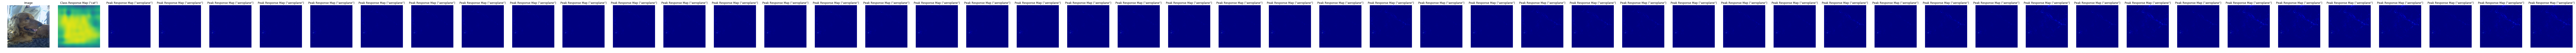

In [17]:
visual_cues = model(input_var[0].view((1,3,448,448)))
print(visual_cues)
if visual_cues is None:
    print('No class peak response detected')
else:
    confidence, class_response_maps, class_peak_responses, peak_response_maps = visual_cues
    _, class_idx = torch.max(confidence, dim=1)
    class_idx = class_idx.item()
    num_plots = 2 + len(peak_response_maps)
    f, axarr = plt.subplots(1, num_plots, figsize=(num_plots * 4, 4))
    axarr[0].imshow(imresize(input_var[0].permute(1, 2, 0), (image_size, image_size), interp='bicubic'))
    axarr[0].set_title('Image')
    axarr[0].axis('off')
    axarr[1].imshow(class_response_maps[0, class_idx].cpu(), interpolation='bicubic')
    axarr[1].set_title('Class Response Map ("%s")' % dataset.classes[class_idx])
    axarr[1].axis('off')
    for idx, (prm, peak) in enumerate(sorted(zip(peak_response_maps, class_peak_responses), key=lambda v: v[-1][-1])):
        axarr[idx + 2].imshow(prm.cpu(), cmap=plt.cm.jet)
        axarr[idx + 2].set_title('Peak Response Map ("%s")' % (dataset.classes[peak[0].item()]))
        axarr[idx + 2].axis('off')